# 1- Train the models

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import scipy.stats as stats




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [2]:
n_model = 20 # number of simulated networks
network_siz = 128
folder_name = f'Sim_fixed_{network_siz}'

# General things

You can specify a saving directory, basically the directory in which the figure can be saved.
The base directory is **hard-coded** in the current version of the code.


In [3]:
loss_type = 'lateral' # I chose lateral deviation as the loss function


phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}


fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
#save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

# #1: Estimating TDR and uniform shift

In [4]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 25 # 25 # time point just after the reach onset


ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

data_tdr = []

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        continue
    
    # 1. Load data
    U = get_data(folder_name,model_name,phases,num_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)


    # 2 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    data_tdr.append(data_p)


    # 3 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth_norm = orth_wrt_map(us,tdr) 


    proj_onto_us = project_onto_map(data,us_orth_norm,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * len(labels),  # Repeat mn for the length of labels
    'phase': labels,  # Use labels directly
    'us': u_mean.tolist()  # Convert u_mean Series to list
    }

    T = pd.concat([T, pd.DataFrame(d)], ignore_index=True)

# Plot projection on TDR

Text(0, 0.5, 'TDR Axis 2')

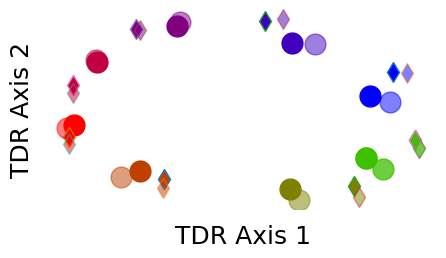

<Figure size 640x480 with 0 Axes>

In [5]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

# Create a scatter plot
fig,ax = plt.subplots(1,1,figsize=(5,5))

data_p = data_tdr[0]

plt.figure()
for i in range(n_cond):
    ax.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i])
    ax.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i])
    ax.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5)
    ax.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    if i == n_cond-1:
        ax.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i],label='NF1')
        ax.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i],label='FF1')
        ax.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5,label='NF2')
        ax.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5,label='FF2')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left = False,bottom = False) 
ax.set_xlabel('TDR Axis 1', fontsize = fontsize_label)
ax.set_ylabel('TDR Axis 2', fontsize = fontsize_label)

#fig.savefig(os.path.join(save_fig,'tdr.pdf'),dpi=300,bbox_inches='tight')

# Plot projection on uniform shift

(0.0, 1.0)

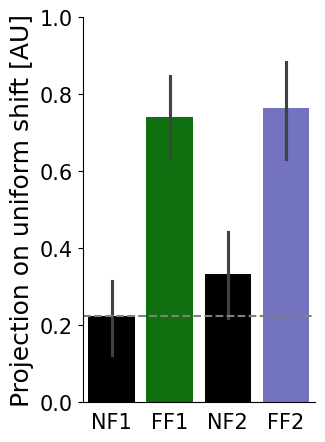

In [6]:
# Assuming T is your DataFrame

fig,ax = plt.subplots(1,1,figsize=(3,5))

mean_nf1 = T.loc[T['phase'] == 'NF1', 'us'].mean()


sb.barplot(x='phase', y='us', data=T,palette=palette_colors,ax=ax,hue='phase',order=None,width=0.8) # ,errorbar=None
ax.axhline(mean_nf1, color='grey',linestyle='--')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('Projection on uniform shift [AU]', fontsize = fontsize_label)
ax.set_ylim([0,1])  # Adjust based on your data


#fig.savefig(os.path.join(save_fig,'proj_on_us_0.pdf'),dpi=300,bbox_inches='tight')

# #2: Perturbation along and opposite uniform shift

In [7]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 25 # 25 # time point just after the reach onset

ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        continue
    
    # 1. Load data
    U = get_data(folder_name,model_name,phases,num_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)


    # 2 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth_norm = orth_wrt_map(us,tdr)


    # 3. perturb hidden
    loss_ff2_p = []
    for dir in [1,-1]: # positive and negative perturbation
        d_hidden = th.from_numpy(dir*us_orth_norm.T*1) # 0.6

        # now lets perturb or not and calculate the saving in behavior
        data_p, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],num_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True) 
        loss_ff2_p.append(loss_p[0][loss_type].mean())

    
    data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],num_hidden=network_siz,return_loss=True) 
    
    loss_ff1 = loss_np[0][loss_type].mean()
    loss_ff2_np = loss_np[1][loss_type].mean()
    

    # make a dataframe
    d = {'size':[network_siz]*4,'N':[N_idx]*4,'m':[mn]*4,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p[0],loss_ff2_p[1]],'phase':['FF1','FF2','FF2+','FF2-']}
    T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

# Plot changes on the loss with or without perturbation

T-statistic: 7.103338633726227
P-value: 9.345119033908786e-07


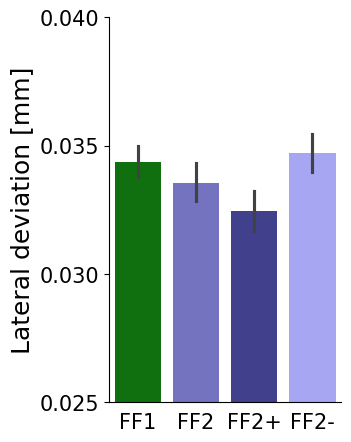

In [8]:
palette_colors2 = {'FF1':(0,0.5,0),'FF2': (0.4,0.4,0.8),'FF2+': (0.2,0.2,0.6),'FF2-': (0.6,0.6,1)}


order = ['FF1','FF2','FF2+','FF2-']



fig,ax = plt.subplots(1,1,figsize=(3,5))
# Plot for T_pos on the first subplot
sb.barplot(x='phase', y='loss', data=T, hue='phase', ax=ax,palette=palette_colors2,order=order,width=0.8)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0.025,0.04])
ax.set_yticks([0.025,0.03,0.035,0.04])
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('Lateral deviation [mm]', fontsize = fontsize_label)



#fig.savefig(os.path.join(save_fig,'FF2_perturb_lat0.pdf'),dpi=300,bbox_inches='tight')


L = T.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(L['FF2'],L['FF2+'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)